In [9]:
%reload_ext autoreload
%autoreload 2
import os
import time
from absl import logging
from typing import Any
from functools import partial

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

from ml_collections import ConfigDict

%cd /hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
%ls

# Import custom modules
from src.layer import get_norm_layer, tensorflow_style_avg_pooling, upsample, dsample
from src.loss import squared_euclidean_distance, entropy_loss, l1_loss, l2_loss
from src.vqvae import VQVAE

/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
batchnorm.ipynb  layers.ipynb  src/         tf_datasets.ipynb
config/          nets.ipynb    test1.ipynb  train_token.ipynb


# Data (we do not need label)

In [10]:
# Directory to save images
data_dir = '/hildafs/projects/phy230056p/junzhez/data/'
data_name = 'mnist'
save_dir = os.path.join(data_dir, data_name)
os.makedirs(save_dir, exist_ok=True)

# Load MNIST dataset using TensorFlow Datasets
dataset_name = 'mnist'
train_split = 'train[:80%]'
val_split = 'train[80%:]'
test_split = 'test'

train_dataset, train_info = tfds.load(dataset_name, data_dir=save_dir, split=train_split, with_info=True)
val_dataset = tfds.load(dataset_name, data_dir=save_dir, split=val_split)
test_dataset = tfds.load(dataset_name, data_dir=save_dir, split=test_split)

# Preprocess dataset
def preprocess(sample):
    image = sample['image']
    image = tf.cast(image, tf.float32) / 255.0
    return {'image': image}

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Convert to numpy arrays and batch the data
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

2024-05-29 18:26:40.450653: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 18:26:40.496198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 18:26:40.532586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

shape = (batch, height, width, channels)
Train data shape: (32, 28, 28, 1)
Val data shape: (32, 28, 28, 1)
Test data shape: (32, 28, 28, 1)


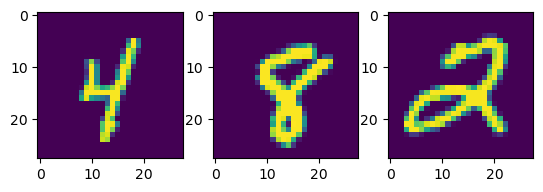

In [11]:
# example training, validation, and test data
train_example = next(iter(train_dataset.as_numpy_iterator()))
val_example = next(iter(val_dataset.as_numpy_iterator()))
test_example = next(iter(test_dataset.as_numpy_iterator()))

print('shape = (batch, height, width, channels)')
print(f"Train data shape: {train_example['image'].shape}")
print(f"Val data shape: {val_example['image'].shape}")
print(f"Test data shape: {test_example['image'].shape}")

# plot example data
fig, axs = plt.subplots(1, 3)
axs[0].imshow(train_example['image'][0])
axs[1].imshow(val_example['image'][0])
axs[2].imshow(test_example['image'][0])
plt.show()

# Config

In [11]:
# Create the VQVAE model configuration
config = ConfigDict()
config.vqvae = ConfigDict()

# encoder configs
config.vqvae.filters = 64
config.vqvae.num_res_blocks = 2
config.vqvae.channel_multipliers = [1, 1, 2]
config.vqvae.embedding_dim = 32 # output dimension of the encoder
config.vqvae.conv_downsample = False # whether to use convolutional downsampling or average pooling downsampling in the encoder/decoder
config.vqvae.conv_fn = "conv" # the standard convolutional layer in the residual block, and in the encoder (flax.linen.Conv)
config.vqvae.norm_type = "GN" # normalization layer in the residual block
config.vqvae.activation_fn = "swish" # activation function in the residual block, and in the encoder

# additional decoder configs
config.vqvae.output_dim = 1 # N of decoder output channels = N color channels 


config.vqvae.codebook_size = 512
config.vqvae.commitment_cost = 0.25

config.vqvae.entropy_loss_ratio = 0.0
config.vqvae.entropy_loss_type = "softmax"
config.vqvae.entropy_temperature = 1.0

In [ ]:
config.vqvae = ml_collections.ConfigDict()
# config.vqvae.quantizer = "vq"
config.vqvae.codebook_size = 1024

config.vqvae.entropy_loss_ratio = 0.1
config.vqvae.entropy_temperature = 0.01
config.vqvae.entropy_loss_type = "softmax"
config.vqvae.commitment_cost = 0.25

config.vqvae.filters = 128
config.vqvae.num_res_blocks = 2
config.vqvae.channel_multipliers = [1, 1, 2, 2, 4]
config.vqvae.embedding_dim = 256
config.vqvae.conv_downsample = False
config.vqvae.activation_fn = "swish"
config.vqvae.norm_type = "GN"

In [12]:
# Create the VQVAE model
vqvae = VQVAE(config=config, train=True)

In [15]:
# Define a simple training state to hold the model and optimizer
class TrainState(train_state.TrainState):
    batch_stats: Any = None

def create_train_state(rng, config, learning_rate):
    vqvae = VQVAE(config=config, train=True)
    variables = vqvae.init(rng, {'image': jnp.ones([1, 28, 28, 1]), 'train': True})
    params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=vqvae.apply, params=params, tx=tx, batch_stats=batch_stats)

def l2_loss(y_true, y_pred):
    # y_true has shape (batch_size, height, width, color_channels=1)
    diff = y_true - y_pred
    diff = jnp.asarray(diff, jnp.float32)
    return jnp.mean(jnp.square(diff))

# Training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        result, new_model_state = state.apply_fn(variables, {'image': batch, 'train': True}, mutable=['batch_stats'])
        reconstructions, result_dict = result
        # result_dict has keys: 
        # dict_keys(['quantizer_loss', 'e_latent_loss', 'q_latent_loss', 'entropy_loss', 'encodings', 'encoding_indices', 'raw'])
        recon_loss = l2_loss(batch, reconstructions)
        quantizer_loss = result_dict['quantizer_loss']
        total_loss = recon_loss + quantizer_loss
        return total_loss, (recon_loss, quantizer_loss, new_model_state)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (total_loss, (recon_loss, quantizer_loss, new_model_state)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, total_loss, recon_loss, quantizer_loss



# Validation step
@jax.jit
def eval_step(state, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    print(variables.keys()) # dict_keys(['params', 'batch_stats'])

    print(variables['params'].keys()) # dict_keys(['decoder', 'encoder', 'quantizer'])
    print(variables['params']['decoder'].keys()) # dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'Conv_2', 'Conv_3', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
    print(variables['params']['encoder'].keys()) # dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
    print(variables['params']['quantizer'].keys()) # dict_keys(['codebook'])

    print(variables['batch_stats'].keys()) # dict_keys(['decoder', 'encoder'])
    print(variables['batch_stats']['decoder'].keys()) # dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
    print(variables['batch_stats']['encoder'].keys()) # dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])

    # access train in variables
    reconstructions, _ = state.apply_fn(variables, {'image': batch, 'train': False}, mutable=False)
    recon_loss = l2_loss(batch, reconstructions)
    quantizer_loss = 0  # Assuming quantizer_loss is not required during evaluation
    total_loss = recon_loss + quantizer_loss
    return total_loss, recon_loss, quantizer_loss



def train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate):
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, config, learning_rate)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training
        for batch in train_dataset.as_numpy_iterator():
            state, total_loss, recon_loss, quantizer_loss = train_step(state, batch)
        
        # Validation
        val_loss = 0
        val_recon_loss = 0
        val_quantizer_loss = 0
        val_steps = 0
        for batch in val_dataset.as_numpy_iterator():
            loss, recon_loss, quantizer_loss = eval_step(state, batch)
            val_loss += loss
            val_recon_loss += recon_loss
            val_quantizer_loss += quantizer_loss
            val_steps += 1
        val_loss /= val_steps
        val_recon_loss /= val_steps
        val_quantizer_loss /= val_steps

        epoch_time = time.time() - start_time
        print(
            f"Epoch {epoch+1}, Time: {epoch_time:.2f}s, "
            f"Train Loss: {total_loss:.4f}, "
            f"Validation Loss: {val_loss:.4f}, "
            f"Recon Loss: {val_recon_loss:.4f}, "
            f"Quantizer Loss: {val_quantizer_loss:.4f}"
        )



# Start training
num_epochs = 10
learning_rate = 1e-3

train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate)

2024-05-29 02:50:51.788571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


dict_keys(['params', 'batch_stats'])
dict_keys(['decoder', 'encoder', 'quantizer'])
dict_keys(['decoder', 'encoder'])
dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'Conv_2', 'Conv_3', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
dict_keys(['BatchNorm_0', 'Conv_0', 'Conv_1', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
dict_keys(['codebook'])
dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])
dict_keys(['BatchNorm_0', 'ResBlock_0', 'ResBlock_1', 'ResBlock_2', 'ResBlock_3', 'ResBlock_4', 'ResBlock_5', 'ResBlock_6', 'ResBlock_7'])


2024-05-29 02:50:52.039960: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ModifyScopeVariableError: Cannot update variable "mean" in "/encoder/ResBlock_0/BatchNorm_0" because collection "batch_stats" is immutable. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ModifyScopeVariableError)

In [16]:
rng = jax.random.PRNGKey(0)
state = create_train_state(rng, config, learning_rate)

In [20]:
state.__dict__.keys()

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state', 'batch_stats'])

In [23]:
state.params.keys()

dict_keys(['encoder', 'quantizer', 'decoder'])

In [5]:
# Define a simple training state to hold the model and optimizer
class TrainState(train_state.TrainState):
    batch_stats: Any = None

def create_train_state(rng, config, learning_rate):
    vqvae = VQVAE(config=config, train=True)
    variables = vqvae.init(rng, {'image': jnp.ones([1, 28, 28, 1]), 'train': True})
    params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=vqvae.apply, params=params, tx=tx, batch_stats=batch_stats)


def l2_loss(y_true, y_pred):
    diff = y_true - y_pred
    diff = jnp.asarray(diff, jnp.float32)
    return jnp.mean(jnp.square(diff))


# Training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        outputs, new_model_state = state.apply_fn(
            variables, {'image': batch, 'train': True}, mutable=['batch_stats']
        )
        reconstructions, quantizer_loss = outputs
        recon_loss = l2_loss(batch, reconstructions)
        total_loss = recon_loss + quantizer_loss
        return total_loss, (recon_loss, quantizer_loss), new_model_state
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (total_loss, (recon_loss, quantizer_loss), new_model_state), grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
    return new_state, total_loss, recon_loss, quantizer_loss


# Validation step
@jax.jit
def eval_step(state, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    outputs = state.apply_fn(
        variables, {'image': batch, 'train': False}, mutable=False
    )
    reconstructions, quantizer_loss = outputs
    recon_loss = l2_loss(batch, reconstructions)
    total_loss = recon_loss + quantizer_loss
    return total_loss, recon_loss, quantizer_loss


def train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate):
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, config, learning_rate)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training
        for batch in train_dataset.as_numpy_iterator():
            state, total_loss, recon_loss, quantizer_loss = train_step(state, batch)
        
        # Validation
        val_loss = 0
        val_recon_loss = 0
        val_quantizer_loss = 0
        val_steps = 0
        for batch in val_dataset.as_numpy_iterator():
            loss, recon_loss, quantizer_loss = eval_step(state, batch)
            val_loss += loss
            val_recon_loss += recon_loss
            val_quantizer_loss += quantizer_loss
            val_steps += 1
        val_loss /= val_steps
        val_recon_loss /= val_steps
        val_quantizer_loss /= val_steps

        epoch_time = time.time() - start_time
        logging.info(
            f"Epoch {epoch+1}, Time: {epoch_time:.2f}s, "
            f"Train Loss: {total_loss:.4f}, "
            f"Validation Loss: {val_loss:.4f}, "
            f"Recon Loss: {val_recon_loss:.4f}, "
            f"Quantizer Loss: {val_quantizer_loss:.4f}"
        )


# Start training
num_epochs = 10
learning_rate = 1e-3

train_and_evaluate(config, train_dataset, val_dataset, num_epochs, learning_rate)

2024-05-29 01:55:55.130233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: too many values to unpack (expected 2)